In [4]:
# Check torch version and CUDA status if GPU is enabled.
import torch
print(torch.__version__)
print(torch.cuda.is_available()) # Should return True when GPU is enabled. 

# Use GPU if it's available
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device)

2.9.1
False
mps


In [5]:
import json
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import time
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import models
from torchvision import transforms

In [6]:
root_dir = "image-classifier/"
data_dir = root_dir + "flowers"
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [7]:
# TODO: Define your transforms for the training, validation, and testing sets
data_transforms = {
    "train": transforms.Compose([
        transforms.RandomRotation(30),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
    "valid": transforms.Compose([
        transforms.Resize(255),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
    "test": transforms.Compose([
        transforms.Resize(255),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])
}

# TODO: Load the datasets with ImageFolder
image_datasets = {
    "train": datasets.ImageFolder(train_dir, transform=data_transforms["train"]),
    "valid": datasets.ImageFolder(valid_dir, transform=data_transforms["valid"]),
    "test": datasets.ImageFolder(test_dir, transform=data_transforms["test"]),
}

# TODO: Using the image datasets and the trainforms, define the dataloaders
dataloaders = {
    "train": DataLoader(image_datasets["train"], batch_size=64, shuffle=True),
    "valid": DataLoader(image_datasets["valid"], batch_size=64, shuffle=False),
    "test": DataLoader(image_datasets["test"], batch_size=64, shuffle=False),
}

In [8]:
with open(root_dir + 'cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

In [9]:
num_classes = len(cat_to_name)

model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)

for param in model.parameters():
    param.requires_grad = False

In [10]:
print(model.classifier)

classifier = nn.Sequential(
    nn.Linear(25088, 4096),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(4096, num_classes),
    nn.LogSoftmax(dim=1)
)

model.classifier = classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)


In [11]:
criterion = nn.NLLLoss()

optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

In [ ]:
model.to(device)

epochs = 5
steps = 0
running_loss = 0
print_every = 5

print(f"Total training batches: {len(dataloaders['train'])}")

for epoch in range(epochs):
    epoch_start = time.time()

    for inputs, labels in dataloaders["train"]:
        print(f"Running training at step {steps}...")

        batch_start = time.time()
        steps += 1

        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        print(f"Device = {device}; Time per batch: {(time.time() - batch_start):.3f} seconds")

        if steps % print_every == 0:
            print(f"Running validation at step {steps}...")

            validation_start = time.time()

            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in dataloaders["valid"]:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    
                    test_loss += batch_loss.item()
                    
                    # Calculate accuracy
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            
            print(f"Device = {device}; Time per validation: {(time.time() - validation_start):.3f} seconds") 

            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Validation loss: {test_loss/len(dataloaders['valid']):.3f}.. "
                  f"Validation accuracy: {accuracy/len(dataloaders['valid']):.3f}")
            running_loss = 0
            model.train()

    print(f"Device = {device}; Time per epoch: {(time.time() - epoch_start):.3f} seconds")

In [12]:
model.eval()
accuracy = 0

with torch.no_grad():
    for inputs, labels in dataloaders["test"]:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model.forward(inputs)

        ps = torch.exp(outputs)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

print(f"Test accuracy: {accuracy/len(dataloaders['test']):.3f}")

RuntimeError: Input type (MPSFloatType) and weight type (torch.FloatTensor) should be the same

In [ ]:
checkpoint = {
    "state_dict": model.state_dict(),
    "class_to_idx": image_datasets["train"].class_to_idx,
    "classifier": model.classifier,
    "epochs": epochs
}

torch.save(checkpoint, root_dir + "checkpoint.pth")

In [13]:
checkpoint_loaded = torch.load(root_dir + "checkpoint.pth", weights_only=False)

model_loaded = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)

for param in model_loaded.parameters():
    param.requires_grad = False

model_loaded.classifier = checkpoint_loaded["classifier"]
model_loaded.load_state_dict(checkpoint_loaded["state_dict"])
model_loaded.class_to_idx = checkpoint_loaded["class_to_idx"]

model_loaded.eval()

model_loaded.to(device)

print(f"Trained for {checkpoint_loaded['epochs']} epochs")
print(f"Number of classes: {len(checkpoint_loaded['class_to_idx'])}")

Trained for 5 epochs
Number of classes: 102


In [14]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''

    # Resize so shortest side is 256, maintaining aspect ratio
    width, height = image.size
    ratio = 256 / min(width, height)
    image = image.resize((int(width * ratio), int(height * ratio)))
    
    # Center crop to 224x224
    crop_left = (image.width - 224) / 2
    crop_top = (image.height - 224) / 2
    image = image.crop((crop_left, crop_top, crop_left + 224, crop_top + 224))

    # Convert to numpy array, scale to 0-1, and normalize
    np_image = np.array(image) / 255.0
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    np_image = (np_image - mean) / std

    # Set color channel to first dimension
    return np_image.transpose((2, 0, 1))

In [15]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

In [16]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    with Image.open(image_path) as image:
        np_image = process_image(image)
        tensor_image = torch.from_numpy(np_image).float().unsqueeze(0)
        tensor_image = tensor_image.to(next(model.parameters()).device)

        model.eval()
        with torch.no_grad():
            output = model(tensor_image)

        # Get probabilities
        ps = torch.softmax(output, dim=1)

        # Get top-k probabilities and indices
        top_p, top_idx = ps.topk(topk, dim=1)

        # Convert to numpy arrays
        top_p = top_p.cpu().numpy().squeeze()
        top_idx = top_idx.cpu().numpy().squeeze()

        # Invert class_to_idx to get idx_to_class
        idx_to_class = {v: k for k, v in model.class_to_idx.items()}

        # Map indices to class labels
        top_classes = [idx_to_class[idx] for idx in top_idx]

        return top_p, top_classes

In [ ]:
def display_prediction(image_path, model, cat_to_name, topk=5):
    """Display an image alongside a bar chart of the top-k predicted classes."""

    # Get predictions
    probs, classes = predict(image_path, model, topk)

    # Get flower names
    flower_names = [cat_to_name[cls] for cls in classes]

    # Create figure with two subplots
    _, (ax1, ax2) = plt.subplots(figsize=(12, 5), ncols=2)

    # Display image
    with Image.open(image_path) as img:
        ax1.imshow(img)
    ax1.axis('off')
    ax1.set_title(flower_names[0])

    # Display bar chart (horizontal, with highest probability at top)
    y_pos = np.arange(len(flower_names))
    ax2.barh(y_pos, probs)
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(flower_names)
    ax2.invert_yaxis()  # Highest probability at top

    plt.tight_layout()
    plt.show()

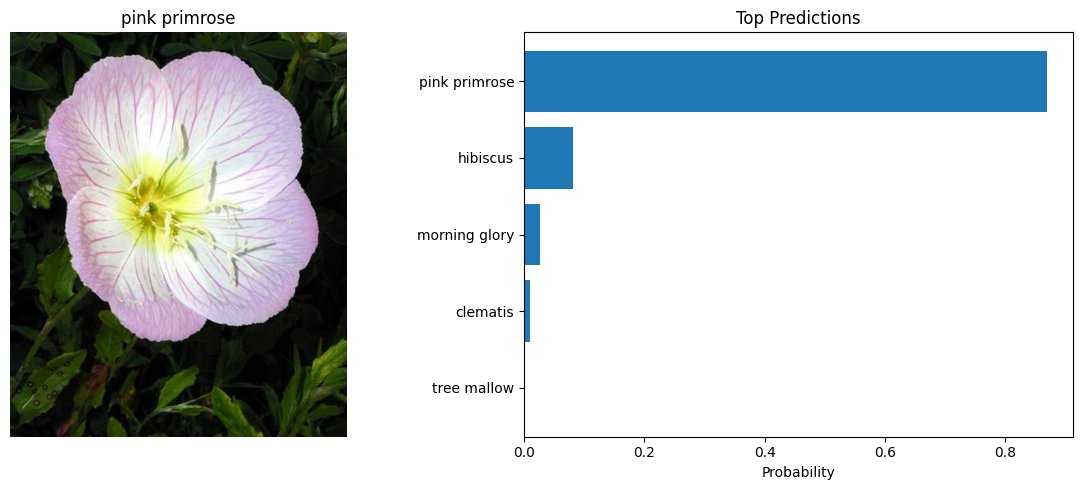

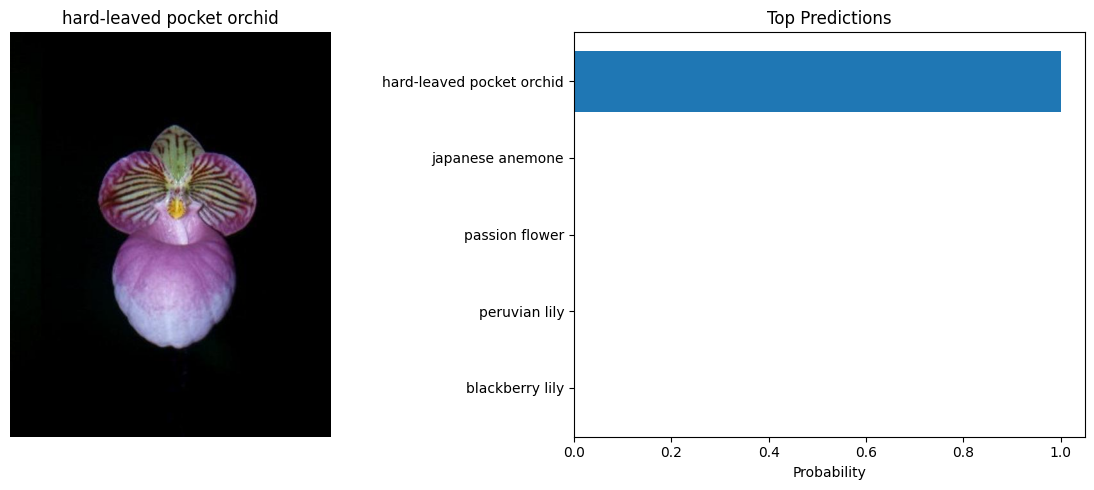

In [22]:
display_prediction(test_dir + "/1/image_06743.jpg", model_loaded, cat_to_name)
display_prediction(test_dir + "/2/image_05100.jpg", model_loaded, cat_to_name)